In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredLogarithmicError, MeanSquaredError,Huber
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("C:/Users/anand/Documents/Capstone Files Dump/Test case 1/processed_cryptodata.csv")

# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# List of cryptocurrencies
cryptos = df['Crypto'].unique()

# Directory to save models
model_dir = "crypto_lstm_models"
os.makedirs(model_dir, exist_ok=True)

# Selecting relevant columns for LSTM
features = ['Open', 'High', 'Low', 'Volume', 'VWAP', 'Volatility', 'Price_Change', 'RSI', 'MACD',
            'MA_7', 'MA_14', 'EMA_7', 'EMA_14', 'Rolling_Std_7', 'Rolling_Std_14',
            'Day_of_Week', 'Month', 'Week_of_Year', 'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3']

target = 'Close'
#sequence_length = 10


C:\Users\anand\AppData\Local\Temp\ipykernel_10600\1654293599.py:18: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
import keras_tuner as kt
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define Cryptocurrency
crypto = "Bitcoin"
print(f"🚀 Training Optimized LSTM model for {crypto}...")

# Load dataset
df = pd.read_csv("C:/Users/anand/Documents/Capstone Files Dump/Test case 1/processed_cryptodata.csv")

# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# Selecting relevant columns for LSTM
features = ['Open', 'High', 'Low', 'Volume', 'VWAP', 'Volatility', 'Price_Change', 'RSI', 'MACD',
            'MA_7', 'MA_14', 'EMA_7', 'EMA_14', 'Rolling_Std_7', 'Rolling_Std_14',
            'Day_of_Week', 'Month', 'Week_of_Year', 'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3']
target = 'Close'

# Filter dataset for Bitcoin
crypto_df = df[df['Crypto'] == crypto].drop(columns=['Crypto']).dropna()

# ✅ Use separate scalers for features & target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

crypto_scaled_features = scaler_features.fit_transform(crypto_df[features])  
target_scaled = scaler_target.fit_transform(crypto_df[[target]])  

# Combine after scaling
crypto_scaled = np.hstack((crypto_scaled_features, target_scaled))
crypto_scaled = pd.DataFrame(crypto_scaled, columns=features + [target], index=crypto_df.index)

# Train-Test Split
train_size = int(len(crypto_scaled) * 0.8)
train, test = crypto_scaled.iloc[:train_size], crypto_scaled.iloc[train_size:]

# ✅ Increase sequence length to 60-120
def create_sequences(data, seq_length):
    x_data, y_data = [], []
    for i in range(seq_length, len(data)):
        x_data.append(data.iloc[i-seq_length:i][features].values)
        y_data.append(data.iloc[i][target])
    return np.array(x_data), np.array(y_data)

# Define Model for Keras Tuner
def build_model(hp):
    sequence_length = hp.Int('sequence_length', min_value=60, max_value=120, step=15)

    model = Sequential([
        Input(shape=(sequence_length, len(features))),
        Bidirectional(LSTM(hp.Int('units_1', min_value=256, max_value=1024, step=128), return_sequences=True)),
        Dropout(hp.Float('dropout_1', 0.005, 0.02, step=0.005)),  # ✅ Reduce Dropout

        LSTM(hp.Int('units_2', min_value=256, max_value=1024, step=128), return_sequences=True),
        Dropout(hp.Float('dropout_2', 0.005, 0.02, step=0.005)),

        LSTM(hp.Int('units_3', min_value=256, max_value=1024, step=128), return_sequences=False),
        Dropout(hp.Float('dropout_3', 0.005, 0.02, step=0.005)),

        Dense(hp.Int('dense_units', 128, 512, step=128), activation='tanh'),
        Dense(1, activation='linear')
    ])

    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.0001, 0.0003, 0.0005])),
                  loss=Huber(delta=1000))  # ✅ Larger delta for Bitcoin
    return model

# ✅ Increase trials for better tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=30,  
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name=f'crypto_forecasting_{crypto}',
    overwrite=True
)

# Run Hyperparameter Tuning
x_train, y_train = create_sequences(train, 60)  
x_test, y_test = create_sequences(test, 60)

tuner.search(x_train, y_train, validation_data=(x_test, y_test), epochs=40, batch_size=64, verbose=1)

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
optimal_sequence_length = best_hps.get('sequence_length')

# Train Final Model with Best Sequence Length
x_train, y_train = create_sequences(train, optimal_sequence_length)
x_test, y_test = create_sequences(test, optimal_sequence_length)

model = build_model(best_hps)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=80, batch_size=64, verbose=1, callbacks=[early_stopping])

# ✅ Save Model
model.save(os.path.join("models", f"LSTM_{crypto}.h5"))
print(f"✅ Model saved: models/LSTM_{crypto}.h5")

# Make Predictions
y_pred = model.predict(x_test)

# ✅ Fix inverse transformation issue
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1))[:, 0]
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))[:, 0]

# ✅ Plot Predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index[optimal_sequence_length:], y_test_rescaled, label="Actual", color="blue")
plt.plot(test.index[optimal_sequence_length:], y_pred_rescaled, label="LSTM Predicted", color="orange")
plt.title(f"LSTM Model - Actual vs Predicted for {crypto}")
plt.legend()
plt.show()

# ✅ Compute Performance Metrics
performance_metrics = {
    "MAE": mean_absolute_error(y_test_rescaled, y_pred_rescaled),
    "MSE": mean_squared_error(y_test_rescaled, y_pred_rescaled),
    "RMSE": np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled)),
    "R-squared": r2_score(y_test_rescaled, y_pred_rescaled)
}

# ✅ Print & Save Metrics
print(f"📊 Performance for {crypto}: {performance_metrics}")
pd.DataFrame([performance_metrics]).to_csv(f"LSTM_Performance_{crypto}.csv", index=False)



Trial 12 Complete [00h 08m 31s]
val_loss: 0.0012375309597700834

Best val_loss So Far: 0.0009414664236828685
Total elapsed time: 01h 31m 05s

Search: Running Trial #13

Value             |Best Value So Far |Hyperparameter
120               |120               |sequence_length
640               |1024              |units_1
0.015             |0.005             |dropout_1
896               |896               |units_2
0.015             |0.005             |dropout_2
256               |896               |units_3
0.01              |0.01              |dropout_3
512               |128               |dense_units
0.0001            |0.0001            |learning_rate

Epoch 1/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 0.0339 - val_loss: 0.0519
Epoch 2/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.0061 - val_loss: 9.4743e-04
Epoch 3/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.0025 - val_loss: 0.0268
Epoch 4/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.0012 - val_loss: 0.0024
Epoch 5

Trial 15 Complete [00h 01m 40s]
val_loss: 0.0021639401093125343

Best val_loss So Far: 0.0021554986014962196
Total elapsed time: 00h 10m 51s
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - loss: 0.0787 - val_loss: 0.0274
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 0.0011 - val_loss: 0.0087
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 8.6053e-04 - val_loss: 0.0071
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 6.3383e-04 - val_loss: 0.0105
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 5.9239e-04 - val_loss: 0.0057
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 4.6160e-04 - val_loss: 0.0051
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 5.4645e-04 - val_loss: 0.0062
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 5.0586e-04 - val_loss: 0.0059
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 4.4291e-04 - val_loss: 0.0048
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - l

Model saved: models/LSTM_Cardano.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step


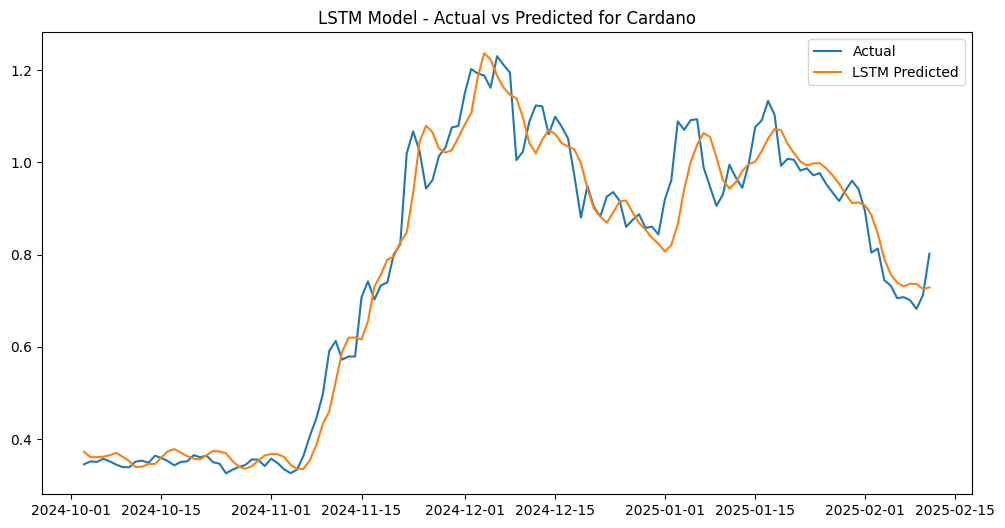

Performance for Cardano: {'MAE': np.float64(0.04251683047464173), 'MSE': np.float64(0.0033971531872231107), 'RMSE': np.float64(0.05828510261827726), 'R-squared': 0.9612474666973181}


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, Huber
import keras_tuner as kt
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define Cryptocurrency
crypto = "Cardano"
print(f"Training LSTM model for {crypto}...")

# Filter dataset for Ethereum
crypto_df = df[df['Crypto'] == crypto].drop(columns=['Crypto'])
crypto_df = crypto_df.dropna()

# Normalize data using MinMaxScaler (adjusted for higher price range)
scaler = MinMaxScaler(feature_range=(0, 1))
crypto_scaled = scaler.fit_transform(crypto_df[features + [target]])
crypto_scaled = pd.DataFrame(crypto_scaled, columns=features + [target], index=crypto_df.index)

# Train-Test Split
train_size = int(len(crypto_scaled) * 0.8)
train, test = crypto_scaled.iloc[:train_size], crypto_scaled.iloc[train_size:]

# Dynamic Sequence Length Tuning
def create_sequences(data, seq_length):
    x_data, y_data = [], []
    for i in range(seq_length, len(data)):
        x_data.append(data.iloc[i-seq_length:i][features].values)
        y_data.append(data.iloc[i][target])
    return np.array(x_data), np.array(y_data)

# Define Model for Keras Tuner
def build_model(hp):
    sequence_length = hp.Int('sequence_length', min_value=5, max_value=30, step=5)

    x_train, y_train = create_sequences(train, sequence_length)
    x_test, y_test = create_sequences(test, sequence_length)

    model = Sequential([
        Input(shape=(sequence_length, len(features))),
        Bidirectional(LSTM(hp.Int('units_1', min_value=128, max_value=512, step=64), return_sequences=True)),
        Dropout(hp.Float('dropout_1', 0.02, 0.1, step=0.02)),

        LSTM(hp.Int('units_2', min_value=128, max_value=512, step=64), return_sequences=True),
        Dropout(hp.Float('dropout_2', 0.02, 0.1, step=0.02)),

        LSTM(hp.Int('units_3', min_value=128, max_value=512, step=64), return_sequences=False),
        Dropout(hp.Float('dropout_3', 0.02, 0.1, step=0.02)),

        Dense(hp.Int('dense_units', 64, 256, step=64), activation='tanh'),
        Dense(1, activation='linear')
    ])

    # Choose loss function dynamically
    loss_fn = hp.Choice('loss_function', ['mse', 'huber'])

    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.0005, 0.001, 0.002, 0.003])),
                  loss=MeanSquaredError() if loss_fn == 'mse' else Huber(delta=50))  # Huber adjusted for large price range
    return model

# Setup Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=15,  # Increase trials for better optimization
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name=f'crypto_forecasting_{crypto}',
    overwrite=True
)

# Run Hyperparameter Tuning
x_train, y_train = create_sequences(train, 10)  # Temporary value, will be optimized
x_test, y_test = create_sequences(test, 10)

tuner.search(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=32, verbose=1)

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
optimal_sequence_length = best_hps.get('sequence_length')

# Train Final Model with Best Sequence Length
x_train, y_train = create_sequences(train, optimal_sequence_length)
x_test, y_test = create_sequences(test, optimal_sequence_length)

model = build_model(best_hps)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])

# Save Model
model.save(os.path.join("models", f"LSTM_{crypto}.h5"))
print(f"Model saved: models/LSTM_{crypto}.h5")

# Make Predictions
y_pred = model.predict(x_test)
y_pred_rescaled = scaler.inverse_transform(np.concatenate((test.iloc[optimal_sequence_length:][features].values, y_pred), axis=1))[:, -1]
y_test_rescaled = scaler.inverse_transform(np.concatenate((test.iloc[optimal_sequence_length:][features].values, y_test.reshape(-1,1)), axis=1))[:, -1]

# Plot Predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index[optimal_sequence_length:], y_test_rescaled, label="Actual")
plt.plot(test.index[optimal_sequence_length:], y_pred_rescaled, label="LSTM Predicted")
plt.title(f"LSTM Model - Actual vs Predicted for {crypto}")
plt.legend()
plt.show()

# Compute Performance Metrics
performance_metrics = {
    "MAE": mean_absolute_error(y_test_rescaled, y_pred_rescaled),
    "MSE": mean_squared_error(y_test_rescaled, y_pred_rescaled),
    "RMSE": np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled)),
    "R-squared": r2_score(y_test_rescaled, y_pred_rescaled)
}

# Print & Save Metrics
print(f"Performance for {crypto}: {performance_metrics}")
pd.DataFrame([performance_metrics]).to_csv(f"LSTM_Performance_{crypto}.csv", index=False)

Trial 10 Complete [00h 00m 06s]
val_loss: 0.0033136564306914806

Best val_loss So Far: 0.002118328120559454
Total elapsed time: 00h 01m 03s
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0438 - val_loss: 0.0285
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027 - val_loss: 0.0070
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015 - val_loss: 0.0087
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - val_loss: 0.0074
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 0.0036
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010 - val_loss: 0.0034
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.4908e-04 - val_loss: 0.0030
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.2486e-04 - val_loss: 0.0046
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.8630e-04 - val_loss: 0.003

Model saved: crypto_lstm_models/LSTM_Chainlink.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


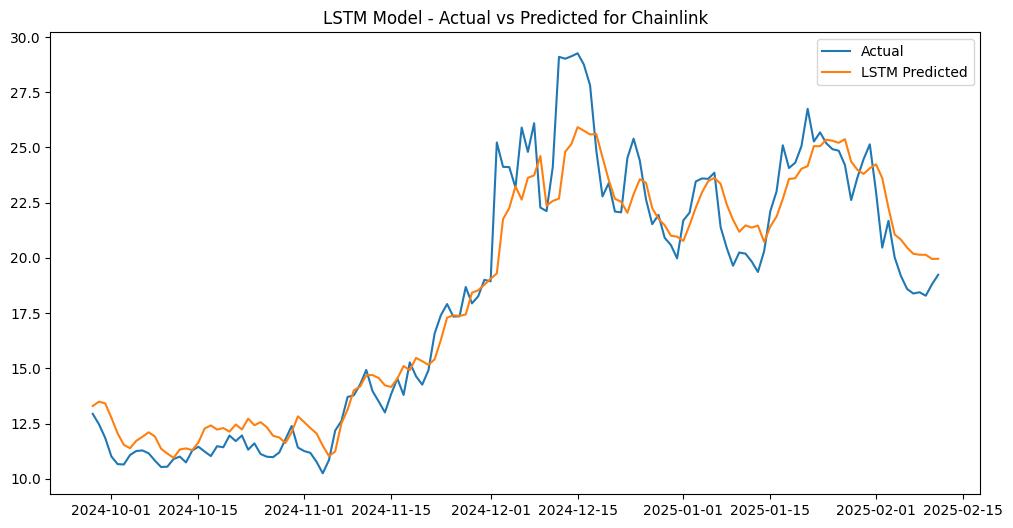

Performance for Chainlink: {'MAE': np.float64(1.1138526092326553), 'MSE': np.float64(2.306127528107638), 'RMSE': np.float64(1.5185939312757832), 'R-squared': 0.9295090150437346}


In [ ]:
sequence_length = 5
# Select Cryptocurrency 
crypto = "Chainlink"  

print(f"Training LSTM model for {crypto}...")

# Filter dataset for the current cryptocurrency
crypto_df = df[df['Crypto'] == crypto].drop(columns=['Crypto'])
crypto_df = crypto_df.dropna()

# Normalize data
scaler = MinMaxScaler()
crypto_scaled = scaler.fit_transform(crypto_df[features + [target]])
crypto_scaled = pd.DataFrame(crypto_scaled, columns=features + [target], index=crypto_df.index)

# Split into train and test
train_size = int(len(crypto_scaled) * 0.8)
train, test = crypto_scaled.iloc[:train_size], crypto_scaled.iloc[train_size:]

if len(test) < sequence_length:
    print(f"Skipping {crypto}, not enough test data.")
else:
    # Create sequences
    x_train, y_train, x_test, y_test = [], [], [], []
    
    for i in range(sequence_length, len(train)):
        x_train.append(train.iloc[i-sequence_length:i][features].values)
        y_train.append(train.iloc[i][target])
    
    for i in range(sequence_length, len(test)):
        x_test.append(test.iloc[i-sequence_length:i][features].values)
        y_test.append(test.iloc[i][target])
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.array(x_test), np.array(y_test)

    # Define KerasTuner Model Builder
    def build_model(hp):
        model = Sequential([
            Input(shape=(sequence_length, len(features))),
            LSTM(hp.Int('units_1', min_value=64, max_value=256, step=64), return_sequences=True),
            Dropout(hp.Choice('dropout_1', [0.02, 0.04, 0.06])),
            LSTM(hp.Int('units_2', min_value=64, max_value=256, step=64), return_sequences=True),
            Dropout(hp.Choice('dropout_2', [0.02, 0.04, 0.06])),
            LSTM(hp.Int('units_3', min_value=64, max_value=256, step=64), return_sequences=False),
            Dropout(hp.Choice('dropout_3', [0.02, 0.04, 0.06])),
            Dense(50, activation='relu'),
            Dense(1)
        ])
        
        model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.005, 0.007, 0.01])),
                      loss=MeanSquaredLogarithmicError())
        return model

    # Set up KerasTuner
    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=10,
        executions_per_trial=1,
        directory='lstm_tuning',
        project_name=f'crypto_forecasting_{crypto}',
        overwrite=True
    )

    # Run Hyperparameter Tuning
    tuner.search(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32, verbose=1)

    # Get Best Hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    model = build_model(best_hps)

    # Train Final Model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])

    # Save Model
    model.save(os.path.join(model_dir, f"LSTM_{crypto}.h5"))
    print(f"Model saved: {model_dir}/LSTM_{crypto}.h5")

    # Make Predictions
    y_pred = model.predict(x_test)
    y_pred_rescaled = scaler.inverse_transform(np.concatenate((test.iloc[sequence_length:][features].values, y_pred), axis=1))[:, -1]
    y_test_rescaled = scaler.inverse_transform(np.concatenate((test.iloc[sequence_length:][features].values, y_test.reshape(-1,1)), axis=1))[:, -1]

    # Plot Predictions
    plt.figure(figsize=(12, 6))
    plt.plot(test.index[sequence_length:], y_test_rescaled, label="Actual")
    plt.plot(test.index[sequence_length:], y_pred_rescaled, label="LSTM Predicted")
    plt.title(f"LSTM Model - Actual vs Predicted for {crypto}")
    plt.legend()
    plt.show()

    # Compute Performance Metrics
    performance_metrics = {
        "MAE": mean_absolute_error(y_test_rescaled, y_pred_rescaled),
        "MSE": mean_squared_error(y_test_rescaled, y_pred_rescaled),
        "RMSE": np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled)),
        "R-squared": r2_score(y_test_rescaled, y_pred_rescaled)
    }

    # Print & Save Metrics
    print(f"Performance for {crypto}: {performance_metrics}")
    pd.DataFrame([performance_metrics]).to_csv(f"LSTM_Performance_{crypto}.csv", index=False)

Trial 10 Complete [00h 00m 08s]
val_loss: 0.013634243048727512

Best val_loss So Far: 0.0005625372286885977
Total elapsed time: 00h 01m 16s
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 4.5874e-04 - val_loss: 0.0018
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.1340e-04 - val_loss: 0.0012
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.5115e-04 - val_loss: 8.5599e-04
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.1583e-04 - val_loss: 8.4480e-04
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.2201e-04 - val_loss: 0.0010
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2093e-04 - val_loss: 0.0011
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.2043e-04 - val_loss: 0.0012
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.2248e-04 - val_loss: 6.3205e-04
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0680e-04 - val_loss: 0.0014
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/

Model saved: crypto_lstm_models/LSTM_Dogecoin.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


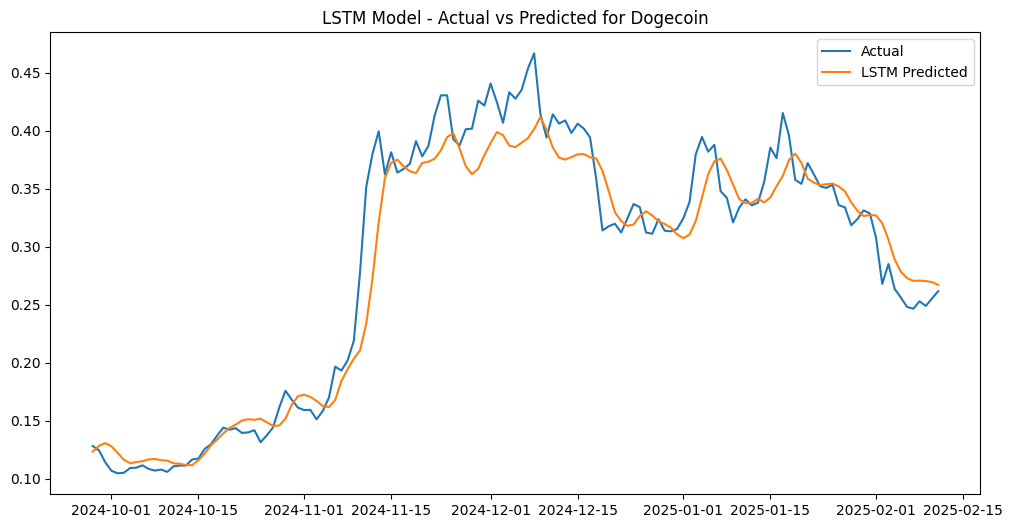

Performance for Dogecoin: {'MAE': np.float64(0.01968699769755673), 'MSE': np.float64(0.0007880630728037766), 'RMSE': np.float64(0.028072461110557737), 'R-squared': 0.9369076889212885}


In [7]:
sequence_length = 5
# Select Cryptocurrency 
crypto = "Dogecoin"  

print(f"Training LSTM model for {crypto}...")

# Filter dataset for the current cryptocurrency
crypto_df = df[df['Crypto'] == crypto].drop(columns=['Crypto'])
crypto_df = crypto_df.dropna()

# Normalize data
scaler = MinMaxScaler()
crypto_scaled = scaler.fit_transform(crypto_df[features + [target]])
crypto_scaled = pd.DataFrame(crypto_scaled, columns=features + [target], index=crypto_df.index)

# Split into train and test
train_size = int(len(crypto_scaled) * 0.8)
train, test = crypto_scaled.iloc[:train_size], crypto_scaled.iloc[train_size:]

if len(test) < sequence_length:
    print(f"Skipping {crypto}, not enough test data.")
else:
    # Create sequences
    x_train, y_train, x_test, y_test = [], [], [], []
    
    for i in range(sequence_length, len(train)):
        x_train.append(train.iloc[i-sequence_length:i][features].values)
        y_train.append(train.iloc[i][target])
    
    for i in range(sequence_length, len(test)):
        x_test.append(test.iloc[i-sequence_length:i][features].values)
        y_test.append(test.iloc[i][target])
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.array(x_test), np.array(y_test)

    # Define KerasTuner Model Builder


    def build_model(hp):
        model = Sequential([
        Input(shape=(sequence_length, len(features))),
        LSTM(hp.Int('units_1', min_value=64, max_value=256, step=64), return_sequences=True),
        Dropout(hp.Float('dropout_1', 0.02, 0.1, step=0.02)),
        
        LSTM(hp.Int('units_2', min_value=64, max_value=256, step=64), return_sequences=True),
        Dropout(hp.Float('dropout_2', 0.02, 0.1, step=0.02)),

        LSTM(hp.Int('units_3', min_value=64, max_value=512, step=64), return_sequences=False),
        Dropout(hp.Float('dropout_3', 0.02, 0.1, step=0.02)),

        Dense(hp.Int('dense_units', 32, 128, step=32), activation='tanh'),
        Dense(1, activation='linear')  # Keep linear for scaled values
    ])
    
        # Choose loss function dynamically
        loss_fn = hp.Choice('loss_function', ['mse', 'huber'])
    
        model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.0005, 0.001, 0.002, 0.003])),
                  loss=MeanSquaredError() if loss_fn == 'mse' else Huber(delta=0.01))
        return model


    # Set up KerasTuner
    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=10,
        executions_per_trial=1,
        directory='lstm_tuning',
        project_name=f'crypto_forecasting_{crypto}',
        overwrite=True
    )

    # Run Hyperparameter Tuning
    tuner.search(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32, verbose=1)

    # Get Best Hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    model = build_model(best_hps)

    # Train Final Model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])

    # Save Model
    model.save(os.path.join(model_dir, f"LSTM_{crypto}.h5"))
    print(f"Model saved: {model_dir}/LSTM_{crypto}.h5")

    # Make Predictions
    y_pred = model.predict(x_test)
    y_pred_rescaled = scaler.inverse_transform(np.concatenate((test.iloc[sequence_length:][features].values, y_pred), axis=1))[:, -1]
    y_test_rescaled = scaler.inverse_transform(np.concatenate((test.iloc[sequence_length:][features].values, y_test.reshape(-1,1)), axis=1))[:, -1]

    # Plot Predictions
    plt.figure(figsize=(12, 6))
    plt.plot(test.index[sequence_length:], y_test_rescaled, label="Actual")
    plt.plot(test.index[sequence_length:], y_pred_rescaled, label="LSTM Predicted")
    plt.title(f"LSTM Model - Actual vs Predicted for {crypto}")
    plt.legend()
    plt.show()

    # Compute Performance Metrics
    performance_metrics = {
        "MAE": mean_absolute_error(y_test_rescaled, y_pred_rescaled),
        "MSE": mean_squared_error(y_test_rescaled, y_pred_rescaled),
        "RMSE": np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled)),
        "R-squared": r2_score(y_test_rescaled, y_pred_rescaled)
    }

    # Print & Save Metrics
    print(f"Performance for {crypto}: {performance_metrics}")
    pd.DataFrame([performance_metrics]).to_csv(f"LSTM_Performance_{crypto}.csv", index=False)

Trial 15 Complete [00h 00m 14s]
val_loss: 0.0037411455996334553

Best val_loss So Far: 0.0016866226214915514
Total elapsed time: 00h 03m 55s
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.6277 - val_loss: 0.0326
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0083 - val_loss: 0.0069
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0027 - val_loss: 0.0051
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0017 - val_loss: 0.0039
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 11

Model saved: models/LSTM_Ethereum.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


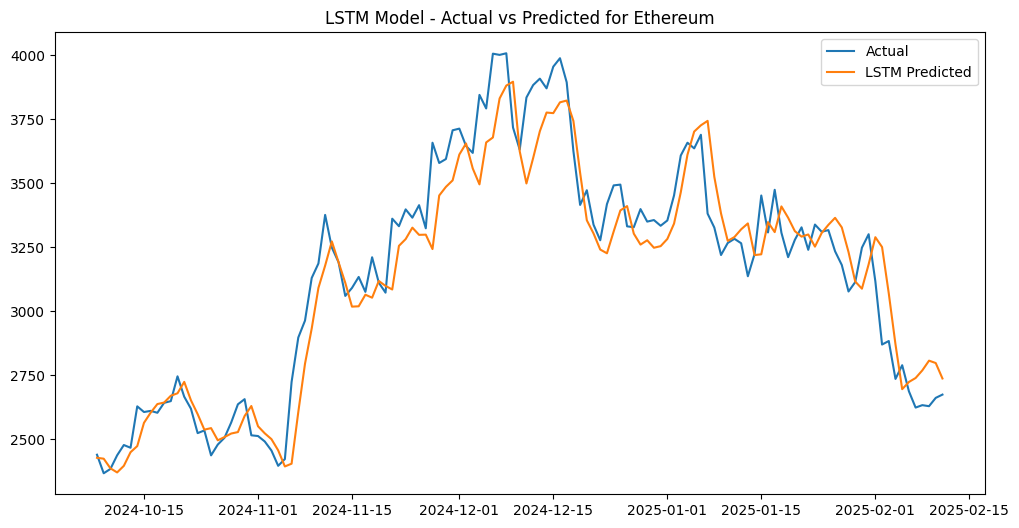

Performance for Ethereum: {'MAE': np.float64(107.03252643826907), 'MSE': np.float64(19497.188413244206), 'RMSE': np.float64(139.6323329793075), 'R-squared': 0.9046415486245081}


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, Huber
import keras_tuner as kt
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define Cryptocurrency
crypto = "Ethereum"
print(f"Training LSTM model for {crypto}...")

# Filter dataset for Ethereum
crypto_df = df[df['Crypto'] == crypto].drop(columns=['Crypto'])
crypto_df = crypto_df.dropna()

# Normalize data using MinMaxScaler (adjusted for higher price range)
scaler = MinMaxScaler(feature_range=(0, 1))
crypto_scaled = scaler.fit_transform(crypto_df[features + [target]])
crypto_scaled = pd.DataFrame(crypto_scaled, columns=features + [target], index=crypto_df.index)

# Train-Test Split
train_size = int(len(crypto_scaled) * 0.8)
train, test = crypto_scaled.iloc[:train_size], crypto_scaled.iloc[train_size:]

# Dynamic Sequence Length Tuning
def create_sequences(data, seq_length):
    x_data, y_data = [], []
    for i in range(seq_length, len(data)):
        x_data.append(data.iloc[i-seq_length:i][features].values)
        y_data.append(data.iloc[i][target])
    return np.array(x_data), np.array(y_data)

# Define Model for Keras Tuner
def build_model(hp):
    sequence_length = hp.Int('sequence_length', min_value=5, max_value=30, step=5)

    x_train, y_train = create_sequences(train, sequence_length)
    x_test, y_test = create_sequences(test, sequence_length)

    model = Sequential([
        Input(shape=(sequence_length, len(features))),
        Bidirectional(LSTM(hp.Int('units_1', min_value=128, max_value=512, step=64), return_sequences=True)),
        Dropout(hp.Float('dropout_1', 0.02, 0.1, step=0.02)),

        LSTM(hp.Int('units_2', min_value=128, max_value=512, step=64), return_sequences=True),
        Dropout(hp.Float('dropout_2', 0.02, 0.1, step=0.02)),

        LSTM(hp.Int('units_3', min_value=128, max_value=512, step=64), return_sequences=False),
        Dropout(hp.Float('dropout_3', 0.02, 0.1, step=0.02)),

        Dense(hp.Int('dense_units', 64, 256, step=64), activation='tanh'),
        Dense(1, activation='linear')
    ])

    # Choose loss function dynamically
    loss_fn = hp.Choice('loss_function', ['mse', 'huber'])

    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.0005, 0.001, 0.002, 0.003])),
                  loss=MeanSquaredError() if loss_fn == 'mse' else Huber(delta=50))  # Huber adjusted for large price range
    return model

# Setup Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=15,  # Increase trials for better optimization
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name=f'crypto_forecasting_{crypto}',
    overwrite=True
)

# Run Hyperparameter Tuning
x_train, y_train = create_sequences(train, 10)  # Temporary value, will be optimized
x_test, y_test = create_sequences(test, 10)

tuner.search(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=32, verbose=1)

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
optimal_sequence_length = best_hps.get('sequence_length')

# Train Final Model with Best Sequence Length
x_train, y_train = create_sequences(train, optimal_sequence_length)
x_test, y_test = create_sequences(test, optimal_sequence_length)

model = build_model(best_hps)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])

# Save Model
model.save(os.path.join("models", f"LSTM_{crypto}.h5"))
print(f"Model saved: models/LSTM_{crypto}.h5")

# Make Predictions
y_pred = model.predict(x_test)
y_pred_rescaled = scaler.inverse_transform(np.concatenate((test.iloc[optimal_sequence_length:][features].values, y_pred), axis=1))[:, -1]
y_test_rescaled = scaler.inverse_transform(np.concatenate((test.iloc[optimal_sequence_length:][features].values, y_test.reshape(-1,1)), axis=1))[:, -1]

# Plot Predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index[optimal_sequence_length:], y_test_rescaled, label="Actual")
plt.plot(test.index[optimal_sequence_length:], y_pred_rescaled, label="LSTM Predicted")
plt.title(f"LSTM Model - Actual vs Predicted for {crypto}")
plt.legend()
plt.show()

# Compute Performance Metrics
performance_metrics = {
    "MAE": mean_absolute_error(y_test_rescaled, y_pred_rescaled),
    "MSE": mean_squared_error(y_test_rescaled, y_pred_rescaled),
    "RMSE": np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled)),
    "R-squared": r2_score(y_test_rescaled, y_pred_rescaled)
}

# Print & Save Metrics
print(f"Performance for {crypto}: {performance_metrics}")
pd.DataFrame([performance_metrics]).to_csv(f"LSTM_Performance_{crypto}.csv", index=False)


Trial 15 Complete [00h 00m 15s]
val_loss: 0.005925252102315426

Best val_loss So Far: 0.004194688517600298
Total elapsed time: 00h 05m 24s
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.1000 - val_loss: 0.0220
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0049 - val_loss: 0.0104
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0022 - val_loss: 0.0101
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0022 - val_loss: 0.0098
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0020 - val_loss: 0.0137
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0024 - val_loss: 0.0115
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0014 - val_loss: 0.0141
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0016 - val_loss: 0.0183
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0023 - val_loss: 0.0251
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0020 - val_loss: 0.0148
Epoch 11/5

Model saved: models/LSTM_Litecoin.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


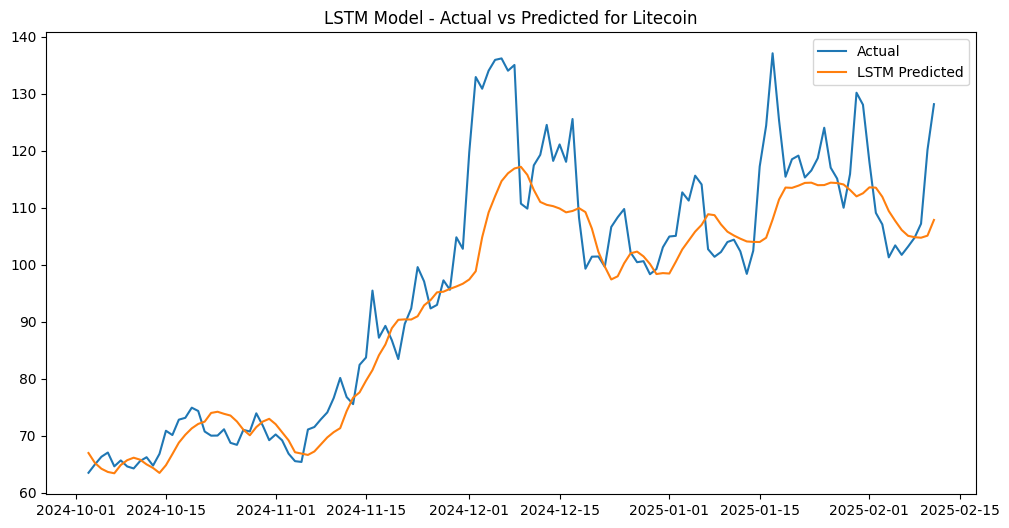

Performance for Litecoin: {'MAE': np.float64(6.165032681429928), 'MSE': np.float64(80.92138770415661), 'RMSE': np.float64(8.995631590063958), 'R-squared': 0.8276044796380966}


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, Huber
import keras_tuner as kt
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define Cryptocurrency
crypto = "Litecoin"
print(f"Training LSTM model for {crypto}...")

# Filter dataset for Litecoin
crypto_df = df[df['Crypto'] == crypto].drop(columns=['Crypto'])
crypto_df = crypto_df.dropna()

# Normalize data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
crypto_scaled = scaler.fit_transform(crypto_df[features + [target]])
crypto_scaled = pd.DataFrame(crypto_scaled, columns=features + [target], index=crypto_df.index)

# Train-Test Split
train_size = int(len(crypto_scaled) * 0.8)
train, test = crypto_scaled.iloc[:train_size], crypto_scaled.iloc[train_size:]

# Dynamic Sequence Length Tuning
def create_sequences(data, seq_length):
    x_data, y_data = [], []
    for i in range(seq_length, len(data)):
        x_data.append(data.iloc[i-seq_length:i][features].values)
        y_data.append(data.iloc[i][target])
    return np.array(x_data), np.array(y_data)

# Define Model for Keras Tuner
def build_model(hp):
    sequence_length = hp.Int('sequence_length', min_value=5, max_value=30, step=5)

    x_train, y_train = create_sequences(train, sequence_length)
    x_test, y_test = create_sequences(test, sequence_length)

    model = Sequential([
        Input(shape=(sequence_length, len(features))),
        Bidirectional(LSTM(hp.Int('units_1', min_value=64, max_value=512, step=64), return_sequences=True)),
        Dropout(hp.Float('dropout_1', 0.02, 0.1, step=0.02)),

        LSTM(hp.Int('units_2', min_value=64, max_value=512, step=64), return_sequences=True),
        Dropout(hp.Float('dropout_2', 0.02, 0.1, step=0.02)),

        LSTM(hp.Int('units_3', min_value=64, max_value=512, step=64), return_sequences=False),
        Dropout(hp.Float('dropout_3', 0.02, 0.1, step=0.02)),

        Dense(hp.Int('dense_units', 32, 128, step=32), activation='tanh'),
        Dense(1, activation='linear')
    ])

    # Choose loss function dynamically
    loss_fn = hp.Choice('loss_function', ['mse', 'huber'])

    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.0005, 0.001, 0.002, 0.003])),
                  loss=MeanSquaredError() if loss_fn == 'mse' else Huber(delta=5))  # Huber Loss adjusted for Litecoin
    return model

# Setup Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=15,  # Increase trials for better optimization
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name=f'crypto_forecasting_{crypto}',
    overwrite=True
)

# Run Hyperparameter Tuning
x_train, y_train = create_sequences(train, 10)  # Temporary value, will be optimized
x_test, y_test = create_sequences(test, 10)

tuner.search(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=32, verbose=1)

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
optimal_sequence_length = best_hps.get('sequence_length')

# Train Final Model with Best Sequence Length
x_train, y_train = create_sequences(train, optimal_sequence_length)
x_test, y_test = create_sequences(test, optimal_sequence_length)

model = build_model(best_hps)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])

# Save Model
model.save(os.path.join("models", f"LSTM_{crypto}.h5"))
print(f"Model saved: models/LSTM_{crypto}.h5")

# Make Predictions
y_pred = model.predict(x_test)
y_pred_rescaled = scaler.inverse_transform(np.concatenate((test.iloc[optimal_sequence_length:][features].values, y_pred), axis=1))[:, -1]
y_test_rescaled = scaler.inverse_transform(np.concatenate((test.iloc[optimal_sequence_length:][features].values, y_test.reshape(-1,1)), axis=1))[:, -1]

# Plot Predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index[optimal_sequence_length:], y_test_rescaled, label="Actual")
plt.plot(test.index[optimal_sequence_length:], y_pred_rescaled, label="LSTM Predicted")
plt.title(f"LSTM Model - Actual vs Predicted for {crypto}")
plt.legend()
plt.show()

# Compute Performance Metrics
performance_metrics = {
    "MAE": mean_absolute_error(y_test_rescaled, y_pred_rescaled),
    "MSE": mean_squared_error(y_test_rescaled, y_pred_rescaled),
    "RMSE": np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled)),
    "R-squared": r2_score(y_test_rescaled, y_pred_rescaled)
}

# Print & Save Metrics
print(f"Performance for {crypto}: {performance_metrics}")
pd.DataFrame([performance_metrics]).to_csv(f"LSTM_Performance_{crypto}.csv", index=False)



Trial 15 Complete [00h 00m 17s]
val_loss: 0.004115979187190533

Best val_loss So Far: 0.0021603864151984453
Total elapsed time: 00h 04m 11s
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0578 - val_loss: 0.0118
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0044 - val_loss: 0.0071
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0020 - val_loss: 0.0050
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0018 - val_loss: 0.0047
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0015 - val_loss: 0.0048
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0015 - val_loss: 0.0039
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0016 - val_loss: 0.0038
Epoch 11/

Model saved: models/LSTM_Polkadot.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


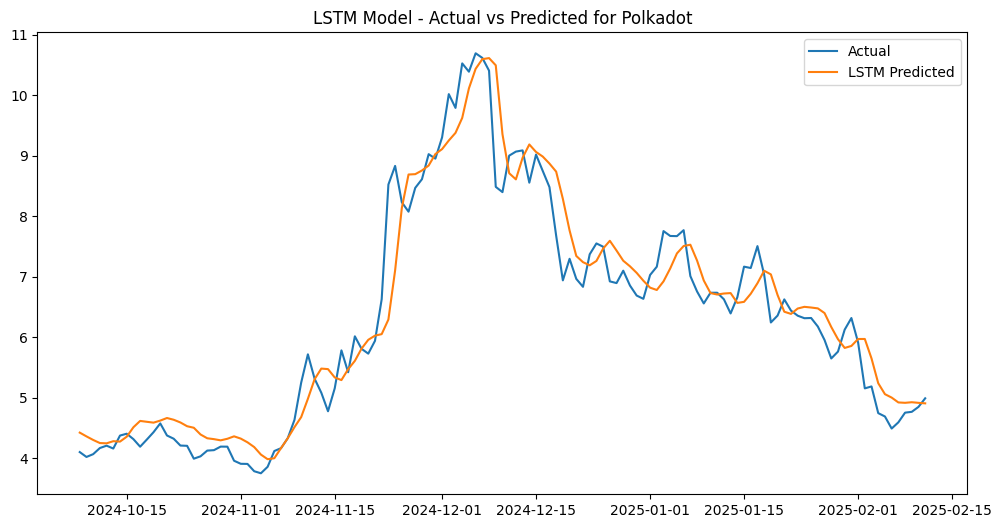

Performance for Polkadot: {'MAE': np.float64(0.359865921854128), 'MSE': np.float64(0.2520848091092155), 'RMSE': np.float64(0.502080480709234), 'R-squared': 0.9257926673347495}


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, Huber
import keras_tuner as kt
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define Cryptocurrency
crypto = "Polkadot"
print(f"Training LSTM model for {crypto}...")

# Filter dataset for Polkadot
crypto_df = df[df['Crypto'] == crypto].drop(columns=['Crypto'])
crypto_df = crypto_df.dropna()

# Normalize data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
crypto_scaled = scaler.fit_transform(crypto_df[features + [target]])
crypto_scaled = pd.DataFrame(crypto_scaled, columns=features + [target], index=crypto_df.index)

# Train-Test Split
train_size = int(len(crypto_scaled) * 0.8)
train, test = crypto_scaled.iloc[:train_size], crypto_scaled.iloc[train_size:]

# Dynamic Sequence Length Tuning
def create_sequences(data, seq_length):
    x_data, y_data = [], []
    for i in range(seq_length, len(data)):
        x_data.append(data.iloc[i-seq_length:i][features].values)
        y_data.append(data.iloc[i][target])
    return np.array(x_data), np.array(y_data)

# Define Model for Keras Tuner
def build_model(hp):
    sequence_length = hp.Int('sequence_length', min_value=5, max_value=30, step=5)

    x_train, y_train = create_sequences(train, sequence_length)
    x_test, y_test = create_sequences(test, sequence_length)

    model = Sequential([
        Input(shape=(sequence_length, len(features))),
        Bidirectional(LSTM(hp.Int('units_1', min_value=64, max_value=512, step=64), return_sequences=True)),
        Dropout(hp.Float('dropout_1', 0.02, 0.1, step=0.02)),

        LSTM(hp.Int('units_2', min_value=64, max_value=512, step=64), return_sequences=True),
        Dropout(hp.Float('dropout_2', 0.02, 0.1, step=0.02)),

        LSTM(hp.Int('units_3', min_value=64, max_value=512, step=64), return_sequences=False),
        Dropout(hp.Float('dropout_3', 0.02, 0.1, step=0.02)),

        Dense(hp.Int('dense_units', 32, 128, step=32), activation='tanh'),
        Dense(1, activation='linear')
    ])

    # Choose loss function dynamically
    loss_fn = hp.Choice('loss_function', ['mse', 'huber'])

    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.0005, 0.001, 0.002, 0.003])),
                  loss=MeanSquaredError() if loss_fn == 'mse' else Huber(delta=1))  # Huber Loss adjusted for Polkadot
    return model

# Setup Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=15,  # Increase trials for better optimization
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name=f'crypto_forecasting_{crypto}',
    overwrite=True
)

# Run Hyperparameter Tuning
x_train, y_train = create_sequences(train, 10)  # Temporary value, will be optimized
x_test, y_test = create_sequences(test, 10)

tuner.search(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=32, verbose=1)

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
optimal_sequence_length = best_hps.get('sequence_length')

# Train Final Model with Best Sequence Length
x_train, y_train = create_sequences(train, optimal_sequence_length)
x_test, y_test = create_sequences(test, optimal_sequence_length)

model = build_model(best_hps)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])

# Save Model
model.save(os.path.join("models", f"LSTM_{crypto}.h5"))
print(f"Model saved: models/LSTM_{crypto}.h5")

# Make Predictions
y_pred = model.predict(x_test)
y_pred_rescaled = scaler.inverse_transform(np.concatenate((test.iloc[optimal_sequence_length:][features].values, y_pred), axis=1))[:, -1]
y_test_rescaled = scaler.inverse_transform(np.concatenate((test.iloc[optimal_sequence_length:][features].values, y_test.reshape(-1,1)), axis=1))[:, -1]

# Plot Predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index[optimal_sequence_length:], y_test_rescaled, label="Actual")
plt.plot(test.index[optimal_sequence_length:], y_pred_rescaled, label="LSTM Predicted")
plt.title(f"LSTM Model - Actual vs Predicted for {crypto}")
plt.legend()
plt.show()

# Compute Performance Metrics
performance_metrics = {
    "MAE": mean_absolute_error(y_test_rescaled, y_pred_rescaled),
    "MSE": mean_squared_error(y_test_rescaled, y_pred_rescaled),
    "RMSE": np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled)),
    "R-squared": r2_score(y_test_rescaled, y_pred_rescaled)
}

# Print & Save Metrics
print(f"Performance for {crypto}: {performance_metrics}")
pd.DataFrame([performance_metrics]).to_csv(f"LSTM_Performance_{crypto}.csv", index=False)


Trial 15 Complete [00h 00m 14s]
val_loss: 0.0006574968574568629

Best val_loss So Far: 0.00042068783659487963
Total elapsed time: 00h 06m 33s
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.1186 - val_loss: 0.0077
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0018 - val_loss: 7.4224e-04
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0010 - val_loss: 9.1040e-04
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0012 - val_loss: 7.1878e-04
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0010 - val_loss: 5.6654e-04
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 8.1673e-04 - val_

Model saved: models/LSTM_Polygon.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


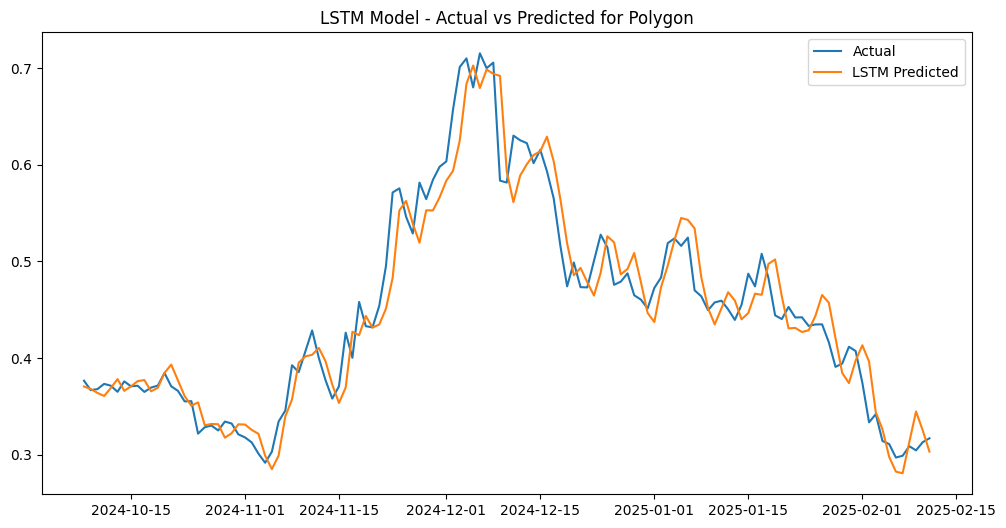

Performance for Polygon: {'MAE': np.float64(0.021787316533113565), 'MSE': np.float64(0.0008495568765167288), 'RMSE': np.float64(0.029147158978478995), 'R-squared': 0.923964529143024}


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, Huber
import keras_tuner as kt
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define Cryptocurrency
crypto = "Polygon"
print(f"Training LSTM model for {crypto}...")

# Filter dataset for Polygon
crypto_df = df[df['Crypto'] == crypto].drop(columns=['Crypto'])
crypto_df = crypto_df.dropna()

# Normalize data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
crypto_scaled = scaler.fit_transform(crypto_df[features + [target]])
crypto_scaled = pd.DataFrame(crypto_scaled, columns=features + [target], index=crypto_df.index)

# Train-Test Split
train_size = int(len(crypto_scaled) * 0.8)
train, test = crypto_scaled.iloc[:train_size], crypto_scaled.iloc[train_size:]

# Dynamic Sequence Length Tuning
def create_sequences(data, seq_length):
    x_data, y_data = [], []
    for i in range(seq_length, len(data)):
        x_data.append(data.iloc[i-seq_length:i][features].values)
        y_data.append(data.iloc[i][target])
    return np.array(x_data), np.array(y_data)

# Define Model for Keras Tuner
def build_model(hp):
    sequence_length = hp.Int('sequence_length', min_value=5, max_value=30, step=5)

    x_train, y_train = create_sequences(train, sequence_length)
    x_test, y_test = create_sequences(test, sequence_length)

    model = Sequential([
        Input(shape=(sequence_length, len(features))),
        Bidirectional(LSTM(hp.Int('units_1', min_value=64, max_value=512, step=64), return_sequences=True)),
        Dropout(hp.Float('dropout_1', 0.02, 0.1, step=0.02)),

        LSTM(hp.Int('units_2', min_value=64, max_value=512, step=64), return_sequences=True),
        Dropout(hp.Float('dropout_2', 0.02, 0.1, step=0.02)),

        LSTM(hp.Int('units_3', min_value=64, max_value=512, step=64), return_sequences=False),
        Dropout(hp.Float('dropout_3', 0.02, 0.1, step=0.02)),

        Dense(hp.Int('dense_units', 32, 128, step=32), activation='tanh'),
        Dense(1, activation='linear')
    ])

    # Choose loss function dynamically
    loss_fn = hp.Choice('loss_function', ['mse', 'huber'])

    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.0005, 0.001, 0.002, 0.003])),
                  loss=MeanSquaredError() if loss_fn == 'mse' else Huber(delta=0.1))  # Huber Loss adjusted for Polygon
    return model

# Setup Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=15,  # Increase trials for better optimization
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name=f'crypto_forecasting_{crypto}',
    overwrite=True
)

# Run Hyperparameter Tuning
x_train, y_train = create_sequences(train, 10)  # Temporary value, will be optimized
x_test, y_test = create_sequences(test, 10)

tuner.search(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=32, verbose=1)

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
optimal_sequence_length = best_hps.get('sequence_length')

# Train Final Model with Best Sequence Length
x_train, y_train = create_sequences(train, optimal_sequence_length)
x_test, y_test = create_sequences(test, optimal_sequence_length)

model = build_model(best_hps)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])

# Save Model
model.save(os.path.join("models", f"LSTM_{crypto}.h5"))
print(f"Model saved: models/LSTM_{crypto}.h5")

# Make Predictions
y_pred = model.predict(x_test)
y_pred_rescaled = scaler.inverse_transform(np.concatenate((test.iloc[optimal_sequence_length:][features].values, y_pred), axis=1))[:, -1]
y_test_rescaled = scaler.inverse_transform(np.concatenate((test.iloc[optimal_sequence_length:][features].values, y_test.reshape(-1,1)), axis=1))[:, -1]

# Plot Predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index[optimal_sequence_length:], y_test_rescaled, label="Actual")
plt.plot(test.index[optimal_sequence_length:], y_pred_rescaled, label="LSTM Predicted")
plt.title(f"LSTM Model - Actual vs Predicted for {crypto}")
plt.legend()
plt.show()

# Compute Performance Metrics
performance_metrics = {
    "MAE": mean_absolute_error(y_test_rescaled, y_pred_rescaled),
    "MSE": mean_squared_error(y_test_rescaled, y_pred_rescaled),
    "RMSE": np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled)),
    "R-squared": r2_score(y_test_rescaled, y_pred_rescaled)
}

# Print & Save Metrics
print(f"Performance for {crypto}: {performance_metrics}")
pd.DataFrame([performance_metrics]).to_csv(f"LSTM_Performance_{crypto}.csv", index=False)


Trial 15 Complete [00h 01m 06s]
val_loss: 0.03448152169585228

Best val_loss So Far: 0.010910951532423496
Total elapsed time: 00h 08m 29s
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 182ms/step - loss: 0.0047 - val_loss: 0.1132
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 2.7482e-04 - val_loss: 0.0754
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 1.4532e-04 - val_loss: 0.0401
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - loss: 1.0970e-04 - val_loss: 0.0214
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - loss: 8.6551e-05 - val_loss: 0.0166
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 7.4875e-05 - val_loss: 0.0188
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - loss: 8.2223e-05 - val_loss: 0.0167
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 7.1269e-05 - val_loss: 0.0141
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 6.5098e-05 - val_loss: 0.0127
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - 

Model saved: models/LSTM_Ripple.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step


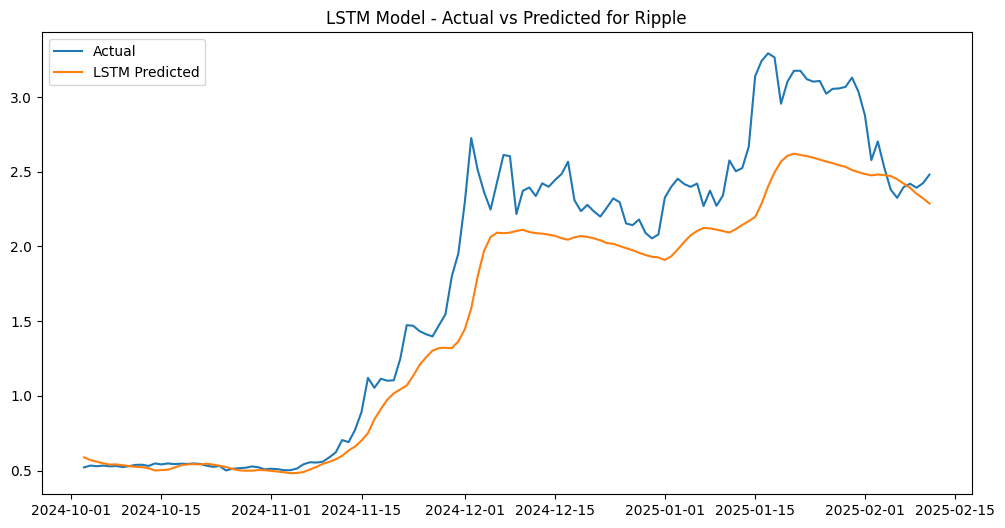

Performance for Ripple: {'MAE': np.float64(0.24300275518292513), 'MSE': np.float64(0.11571465023976407), 'RMSE': np.float64(0.3401685615099727), 'R-squared': 0.8752348821149811}


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, Huber
import keras_tuner as kt
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define Cryptocurrency
crypto = "Ripple"
print(f"Training LSTM model for {crypto}...")

# Filter dataset for Ripple
crypto_df = df[df['Crypto'] == crypto].drop(columns=['Crypto'])
crypto_df = crypto_df.dropna()

# Normalize data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
crypto_scaled = scaler.fit_transform(crypto_df[features + [target]])
crypto_scaled = pd.DataFrame(crypto_scaled, columns=features + [target], index=crypto_df.index)

# Train-Test Split
train_size = int(len(crypto_scaled) * 0.8)
train, test = crypto_scaled.iloc[:train_size], crypto_scaled.iloc[train_size:]

# Dynamic Sequence Length Tuning
def create_sequences(data, seq_length):
    x_data, y_data = [], []
    for i in range(seq_length, len(data)):
        x_data.append(data.iloc[i-seq_length:i][features].values)
        y_data.append(data.iloc[i][target])
    return np.array(x_data), np.array(y_data)

# Define Model for Keras Tuner
def build_model(hp):
    sequence_length = hp.Int('sequence_length', min_value=5, max_value=30, step=5)

    x_train, y_train = create_sequences(train, sequence_length)
    x_test, y_test = create_sequences(test, sequence_length)

    model = Sequential([
        Input(shape=(sequence_length, len(features))),
        Bidirectional(LSTM(hp.Int('units_1', min_value=64, max_value=512, step=64), return_sequences=True)),
        Dropout(hp.Float('dropout_1', 0.02, 0.1, step=0.02)),

        LSTM(hp.Int('units_2', min_value=64, max_value=512, step=64), return_sequences=True),
        Dropout(hp.Float('dropout_2', 0.02, 0.1, step=0.02)),

        LSTM(hp.Int('units_3', min_value=64, max_value=512, step=64), return_sequences=False),
        Dropout(hp.Float('dropout_3', 0.02, 0.1, step=0.02)),

        Dense(hp.Int('dense_units', 32, 128, step=32), activation='tanh'),
        Dense(1, activation='linear')
    ])

    # Choose loss function dynamically
    loss_fn = hp.Choice('loss_function', ['mse', 'huber'])

    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.0005, 0.001, 0.002, 0.003])),
                  loss=MeanSquaredError() if loss_fn == 'mse' else Huber(delta=0.5))  # Adjusted for Ripple's price range
    return model

# Setup Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=15,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name=f'crypto_forecasting_{crypto}',
    overwrite=True
)

# Run Hyperparameter Tuning
x_train, y_train = create_sequences(train, 10)  # Temporary value, will be optimized
x_test, y_test = create_sequences(test, 10)

tuner.search(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=32, verbose=1)

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
optimal_sequence_length = best_hps.get('sequence_length')

# Train Final Model with Best Sequence Length
x_train, y_train = create_sequences(train, optimal_sequence_length)
x_test, y_test = create_sequences(test, optimal_sequence_length)

model = build_model(best_hps)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])

# Save Model
model.save(os.path.join("models", f"LSTM_{crypto}.h5"))
print(f"Model saved: models/LSTM_{crypto}.h5")

# Make Predictions
y_pred = model.predict(x_test)
y_pred_rescaled = scaler.inverse_transform(np.concatenate((test.iloc[optimal_sequence_length:][features].values, y_pred), axis=1))[:, -1]
y_test_rescaled = scaler.inverse_transform(np.concatenate((test.iloc[optimal_sequence_length:][features].values, y_test.reshape(-1,1)), axis=1))[:, -1]

# Plot Predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index[optimal_sequence_length:], y_test_rescaled, label="Actual")
plt.plot(test.index[optimal_sequence_length:], y_pred_rescaled, label="LSTM Predicted")
plt.title(f"LSTM Model - Actual vs Predicted for {crypto}")
plt.legend()
plt.show()

# Compute Performance Metrics
performance_metrics = {
    "MAE": mean_absolute_error(y_test_rescaled, y_pred_rescaled),
    "MSE": mean_squared_error(y_test_rescaled, y_pred_rescaled),
    "RMSE": np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled)),
    "R-squared": r2_score(y_test_rescaled, y_pred_rescaled)
}

# Print & Save Metrics
print(f"Performance for {crypto}: {performance_metrics}")
pd.DataFrame([performance_metrics]).to_csv(f"LSTM_Performance_{crypto}.csv", index=False)


Trial 15 Complete [00h 00m 28s]
val_loss: 0.0022088137920945883

Best val_loss So Far: 0.0018849590560421348
Total elapsed time: 00h 06m 03s
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0340 - val_loss: 0.0041
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0025 - val_loss: 0.0102
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 8.7735e-04 - val_loss: 0.0078
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 9.0203e-04 - val_loss: 0.0026
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0010 - val_loss: 0.0063
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 7.7602e-04 - val_loss: 0.0076
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 8.2672e-04 - val_loss: 0.0036
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 6.9265e-04 - val_l

Model saved: models/LSTM_Solana.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


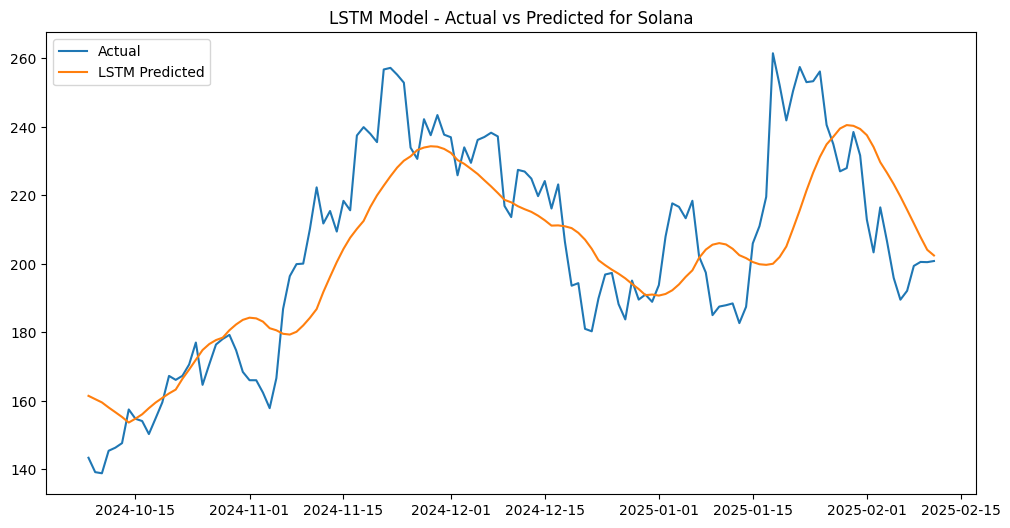

Performance for Solana: {'MAE': np.float64(13.929512707243752), 'MSE': np.float64(319.19132357054923), 'RMSE': np.float64(17.86592632836454), 'R-squared': 0.6697631789323484}


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, Huber
import keras_tuner as kt
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define Cryptocurrency
crypto = "Solana"
print(f"Training LSTM model for {crypto}...")

# Filter dataset for Solana
crypto_df = df[df['Crypto'] == crypto].drop(columns=['Crypto'])
crypto_df = crypto_df.dropna()

# Normalize data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
crypto_scaled = scaler.fit_transform(crypto_df[features + [target]])
crypto_scaled = pd.DataFrame(crypto_scaled, columns=features + [target], index=crypto_df.index)

# Train-Test Split
train_size = int(len(crypto_scaled) * 0.8)
train, test = crypto_scaled.iloc[:train_size], crypto_scaled.iloc[train_size:]

# Dynamic Sequence Length Tuning
def create_sequences(data, seq_length):
    x_data, y_data = [], []
    for i in range(seq_length, len(data)):
        x_data.append(data.iloc[i-seq_length:i][features].values)
        y_data.append(data.iloc[i][target])
    return np.array(x_data), np.array(y_data)

# Define Model for Keras Tuner
def build_model(hp):
    sequence_length = hp.Int('sequence_length', min_value=10, max_value=40, step=5)  # Adjusted for long-term trends

    x_train, y_train = create_sequences(train, sequence_length)
    x_test, y_test = create_sequences(test, sequence_length)

    model = Sequential([
        Input(shape=(sequence_length, len(features))),
        Bidirectional(LSTM(hp.Int('units_1', min_value=128, max_value=512, step=64), return_sequences=True)),
        Dropout(hp.Float('dropout_1', 0.02, 0.1, step=0.02)),

        LSTM(hp.Int('units_2', min_value=128, max_value=512, step=64), return_sequences=True),
        Dropout(hp.Float('dropout_2', 0.02, 0.1, step=0.02)),

        LSTM(hp.Int('units_3', min_value=128, max_value=512, step=64), return_sequences=False),
        Dropout(hp.Float('dropout_3', 0.02, 0.1, step=0.02)),

        Dense(hp.Int('dense_units', 64, 256, step=64), activation='tanh'),
        Dense(1, activation='linear')
    ])

    # Choose loss function dynamically
    loss_fn = hp.Choice('loss_function', ['mse', 'huber'])

    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.0005, 0.001, 0.002, 0.003])),
                  loss=MeanSquaredError() if loss_fn == 'mse' else Huber(delta=10))  # Adjusted for Solana's price range
    return model

# Setup Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=15,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name=f'crypto_forecasting_{crypto}',
    overwrite=True
)

# Run Hyperparameter Tuning
x_train, y_train = create_sequences(train, 15)  # Temporary value, will be optimized
x_test, y_test = create_sequences(test, 15)

tuner.search(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=32, verbose=1)

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
optimal_sequence_length = best_hps.get('sequence_length')

# Train Final Model with Best Sequence Length
x_train, y_train = create_sequences(train, optimal_sequence_length)
x_test, y_test = create_sequences(test, optimal_sequence_length)

model = build_model(best_hps)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])

# Save Model
model.save(os.path.join("models", f"LSTM_{crypto}.h5"))
print(f"Model saved: models/LSTM_{crypto}.h5")

# Make Predictions
y_pred = model.predict(x_test)
y_pred_rescaled = scaler.inverse_transform(np.concatenate((test.iloc[optimal_sequence_length:][features].values, y_pred), axis=1))[:, -1]
y_test_rescaled = scaler.inverse_transform(np.concatenate((test.iloc[optimal_sequence_length:][features].values, y_test.reshape(-1,1)), axis=1))[:, -1]

# Plot Predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index[optimal_sequence_length:], y_test_rescaled, label="Actual")
plt.plot(test.index[optimal_sequence_length:], y_pred_rescaled, label="LSTM Predicted")
plt.title(f"LSTM Model - Actual vs Predicted for {crypto}")
plt.legend()
plt.show()

# Compute Performance Metrics
performance_metrics = {
    "MAE": mean_absolute_error(y_test_rescaled, y_pred_rescaled),
    "MSE": mean_squared_error(y_test_rescaled, y_pred_rescaled),
    "RMSE": np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled)),
    "R-squared": r2_score(y_test_rescaled, y_pred_rescaled)
}

# Print & Save Metrics
print(f"Performance for {crypto}: {performance_metrics}")
pd.DataFrame([performance_metrics]).to_csv(f"LSTM_Performance_{crypto}.csv", index=False)
